# Homework 5: Transfer Learning with MobileNetV2 on the Intel Image Dataset

In this assignment you’ll take a modern pretrained CNN (MobileNetV2) and use it to classify the **Intel Image** dataset (6 scene classes). You’ll start with the network as a **frozen feature extractor**, then progressively **fine-tune** it in different ways. The goal is to understand *why* transfer learning works, how to design a good **classification head**, and how choices like **learning rate**, **learning-rate control (with Reduce on Plateau)**, and **which layers to unfreeze** affect accuracy.

### Learning Objectives

* Understand the difference between **feature extraction** (frozen backbone) and **fine-tuning** (unfrozen).
* How to design and compare **heads** on top of a pretrained backbone.
* Practical training knobs: **LR schedules** (fixed), **ReduceLROnPlateau**, **EarlyStopping**, **Dropout/L2**, and **BatchNorm** in heads.
* Fine-tuning strategies: unfreezing the **whole model**, the **top N layers**, or the **top K conv blocks**.


### Baseline model (starting point)

* `MobileNetV2(weights="imagenet", include_top=False, pooling="avg")`
  → backbone outputs a **1280-D** vector per image (already globally averaged).
* Minimal head: a **single Dense softmax** for 6 classes.
* **Do not** add another pooling layer when `pooling="avg"` is set.

### The five problems (high level)

For each of problems 1 - 4, you will perform 3 experiments, reflect on what you observed, and report the validation accuracy of your best model. 

1. **Problem 1 — Frozen backbone:** Redesign the **head** only (backbone stays frozen). Try ≥3 head variants and basic training knobs.
2. **Problem 2 — Unfreeze all:** Start from your best head and fine-tune the **entire** network with a **small LR**.
3. **Problem 3 — Unfreeze top N layers:** Keep most layers frozen; unfreeze only the **last N** and fine-tune.
4. **Problem 4 — Unfreeze top K blocks:** Unfreeze the **last K MobileNetV2 stages** (e.g., `block_16`, `Conv_1`, etc.) and fine-tune.
5. **Problem 5 — Final Reflection Question**

Use your HW4 CNN results as a reference point. Your aim is to **match or beat** that baseline with transfer learning, and to understand *why* your best choices worked.


In [2]:
import os

# This acts as a shield, hiding the GPU so your original code runs cleanly on the CPU

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"



import tensorflow as tf

print("GPUs detected:", len(tf.config.list_physical_devices('GPU'))) 

# This must print 0

GPUs detected: 0


## 1. Setup and Data Loading


In [3]:
# -------- Standard library --------
import os
import time
import random
from collections import Counter

# Quiet TensorFlow logs (set BEFORE importing TF)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# -------- Third-party --------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import kagglehub

import tensorflow as tf
from tensorflow.keras import layers,models, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    GlobalMaxPooling2D,
    Input,
    MaxPooling2D,
    ReLU,
    SeparableConv2D,
)

from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.preprocessing.image import load_img, img_to_array



he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)

# Reproducibility settings
# -------------------------
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))


/home/michtdizzle/ml-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset Prototype Control (Important)

To speed up development and debugging, you will use a **balanced prototype version of the Intel training dataset** while building and testing your code.

* **During development:**
  Set `PROTO_TOTAL` to an integer (for example, `1400`) to train on a balanced subset of the training data
  (≈ 10% of the full Intel training set).

* **For your final runs:**
  Set `PROTO_TOTAL = None` (or `0`) to train on the **full training dataset**.

#### Notes

* This setting affects the **training pool** of images used to build `train_ds` and `val_ds`.
* The **validation fraction** (`VAL_FRAC`) is unchanged, but the **validation set will be smaller** when you use a prototype training pool.
* The **test set is unchanged** and is always evaluated on the full test dataset.

#### Before You Submit

Before submitting your notebook, make sure that:

* [ ] `PROTO_TOTAL` is set to `None` (or `0`) so the model is trained on the **full training dataset**
* [ ] Your notebook runs **top to bottom without errors**
* [ ] Training completes successfully using the full dataset

Submissions that leave `PROTO_TOTAL` set to a prototype value will **not** receive full credit.


In [4]:
# Prototype control:
#   - Set PROTO_TOTAL to an integer (e.g., 1400) to use a balanced subset (~10% of Intel train)
#   - Set PROTO_TOTAL to None (or 0) to use the full training set

PROTO_TOTAL = 1400   # <-- change to None for full dataset

### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far

In [5]:

def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- Training and testing sets already defined, accessed here as global variables

In [6]:
# Uses globals: train_ds, val_ds, test_ds

def train_and_test(model, 
                   epochs=500,
                   lr_schedule=1e-3,
                   optimizer="Adam",
                   title="Learning Curves",
                   batch_size=64,  # kept for API compatibility; ignored if datasets are batched
                   use_early_stopping=True,
                   patience=8,
                   min_delta=1e-4,
                   callbacks=None,
                   verbose=1,
                   return_history=False):

    print(f"\n{title}\n")

    # Choose optimizer
    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule)
    else:
        opt = optimizer  # assume already an optimizer instance

    # Compile
    model.compile(
        optimizer=opt,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,
        verbose=verbose
    )

    extra_cbs = callbacks or []
    cbs = ([early_stop] if use_early_stopping else []) + extra_cbs

    start = time.time()

    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks=cbs,
        verbose=verbose
    )

    # Best epoch consistent with EarlyStopping monitor
    best_epoch = int(np.argmin(history.history["val_loss"]))
    best_acc   = history.history["val_accuracy"][best_epoch]

    plot_learning_curves(history, title=title)

    test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")

    end = time.time()
    print(f"\nExecution Time: " + format_hms(end - start))

    if return_history:
        return history


### Load the Intel Image Classification Dataset  



In [7]:
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

In [8]:

AUTOTUNE = tf.data.AUTOTUNE

def list_files_and_labels(directory, class_names=None, exts=(".jpg", ".jpeg", ".png")):
    """
    Returns:
      filepaths: np.array[str]
      labels:    np.array[int32]
      class_names_used: list[str] in deterministic order
    """
    if class_names is None:
        class_names = sorted(
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d))
        )
    else:
        # keep only classes that exist in this directory, preserve given order
        class_names = [c for c in class_names if os.path.isdir(os.path.join(directory, c))]

    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    filepaths = []
    labels = []

    for cname in class_names:
        folder = os.path.join(directory, cname)
        for fname in sorted(os.listdir(folder)):  # deterministic within class
            if fname.lower().endswith(exts):
                filepaths.append(os.path.join(folder, fname))
                labels.append(class_to_idx[cname])

    return np.array(filepaths), np.array(labels, dtype=np.int32), class_names


def stratified_split_indices(y, val_frac=0.2, seed=42):
    """
    Deterministic stratified split over indices.
    Returns: train_idx, val_idx (np arrays)
    """
    rng = np.random.default_rng(seed)
    y = np.asarray(y)

    train_idx_list = []
    val_idx_list = []

    classes = np.unique(y)
    for c in classes:
        idx = np.flatnonzero(y == c)
        rng.shuffle(idx)
        n_val = int(np.floor(len(idx) * val_frac))
        val_idx_list.append(idx[:n_val])
        train_idx_list.append(idx[n_val:])

    train_idx = np.concatenate(train_idx_list)
    val_idx   = np.concatenate(val_idx_list)

    # shuffle each split deterministically so batches mix classes
    rng.shuffle(train_idx)
    rng.shuffle(val_idx)

    return train_idx, val_idx


def balanced_subset_indices(y, total=None, per_class=None, seed=42, allow_smaller=True):
    """
    Choose a balanced subset of indices.

    Specify exactly one of:
      - total: desired total number of samples across all classes (realized = floor(total/k)*k)
      - per_class: desired samples per class

    Returns:
      subset_idx: np.array of indices into y
    """
    rng = np.random.default_rng(seed)
    y = np.asarray(y)
    classes = np.unique(y)
    k = len(classes)

    if (total is None) == (per_class is None):
        raise ValueError("Specify exactly one of total or per_class.")

    if per_class is None:
        per_class = int(total // k)  # balanced; realized total = per_class * k

    chosen = []
    for c in classes:
        idx = np.flatnonzero(y == c)
        rng.shuffle(idx)

        if len(idx) < per_class:
            if not allow_smaller:
                raise ValueError(f"Class {c} has only {len(idx)} items, need {per_class}.")
            take = len(idx)
        else:
            take = per_class

        chosen.append(idx[:take])

    subset_idx = np.concatenate(chosen)
    rng.shuffle(subset_idx)  # mix classes deterministically
    return subset_idx


def make_image_dataset(filepaths, labels, img_size=(150, 150), batch_size=32,
                       shuffle=False, seed=42, cache_to_disk=None):
    """
    Builds a tf.data.Dataset that loads images lazily from disk.
    - filepaths: np array of strings
    - labels:    np array of int32
    """
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))

    if shuffle:
        # shuffle file references (cheap), not image tensors
        ds = ds.shuffle(buffer_size=len(filepaths), seed=seed, reshuffle_each_iteration=True)

    def _load_and_preprocess(path, label):
        img_bytes = tf.io.read_file(path)
        img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
        img = tf.image.resize(img, img_size, method="bilinear")
        img = tf.cast(img, tf.float32) / 255.0
        return img, label

    ds = ds.map(_load_and_preprocess, num_parallel_calls=AUTOTUNE)

    if cache_to_disk is not None:
        ds = ds.cache(cache_to_disk)

    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds


# -------------------------
# Intel dataset loading (with optional balanced prototype subset)
# -------------------------

IMG_SIZE    = (150, 150)
INPUT_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE  = 32
VAL_FRAC    = 0.2
SEED        = random_seed  # use your existing seed

# 1) List train files/labels deterministically
train_files_all, train_labels_all, class_names = list_files_and_labels(train_dir)
num_classes = len(class_names)

# 2) Optional: take a balanced prototype subset (no images loaded yet)
if PROTO_TOTAL is not None and PROTO_TOTAL > 0:
    proto_idx = balanced_subset_indices(train_labels_all, total=PROTO_TOTAL, seed=SEED)
    train_files  = train_files_all[proto_idx]
    train_labels = train_labels_all[proto_idx]
else:
    train_files  = train_files_all
    train_labels = train_labels_all

# Report realized size (balanced)
per_class = len(train_files) // num_classes
print(f"Train pool: {len(train_files)} images ({per_class} per class), classes={num_classes}")

# 3) Stratified deterministic split of indices (still no images loaded)
train_idx, val_idx = stratified_split_indices(train_labels, val_frac=VAL_FRAC, seed=SEED)

# 4) Slice file lists for train/val
files_train = train_files[train_idx]
y_train     = train_labels[train_idx]
files_val   = train_files[val_idx]
y_val       = train_labels[val_idx]

print(f"Split sizes: train={len(files_train)}, val={len(files_val)} (VAL_FRAC={VAL_FRAC})")

# 5) Build datasets (lazy image loading)
train_ds = make_image_dataset(files_train, y_train, img_size=IMG_SIZE,
                              batch_size=BATCH_SIZE, shuffle=True, seed=SEED,
                              cache_to_disk=None)  # or "/tmp/train_cache"

val_ds   = make_image_dataset(files_val, y_val, img_size=IMG_SIZE,
                              batch_size=BATCH_SIZE, shuffle=False,
                              cache_to_disk=None)  # or "/tmp/val_cache"

# 6) Test set: keep same class mapping as train
test_files, test_labels, _ = list_files_and_labels(test_dir, class_names=class_names)

# Possible but not recommended: prototype the test set too (balanced). Set to None for full test.
PROTO_TEST_TOTAL = None
if PROTO_TEST_TOTAL is not None and PROTO_TEST_TOTAL > 0:
    test_idx = balanced_subset_indices(test_labels, total=PROTO_TEST_TOTAL, seed=SEED)
    test_files  = test_files[test_idx]
    test_labels = test_labels[test_idx]
    print(f"Test pool: {len(test_files)} images ({len(test_files)//num_classes} per class)")

test_ds = make_image_dataset(test_files, test_labels, img_size=IMG_SIZE,
                             batch_size=BATCH_SIZE, shuffle=False,
                             cache_to_disk=None)


Train pool: 1398 images (233 per class), classes=6
Split sizes: train=1122, val=276 (VAL_FRAC=0.2)


### Examine The Dataset

In [9]:

def show_counts_from_labels(name, labels, class_names):
    c = Counter(labels.tolist())
    counts = {class_names[k]: c.get(k, 0) for k in range(len(class_names))}
    print(f"{name} per-class counts:", counts)

print("class_names:", class_names)
print("train examples:", len(files_train), "val examples:", len(files_val), "test examples:", len(test_files))

show_counts_from_labels("train", y_train, class_names)
show_counts_from_labels("val",   y_val,   class_names)
show_counts_from_labels("test",  test_labels, class_names)


class_names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
train examples: 1122 val examples: 276 test examples: 3000
train per-class counts: {'buildings': 187, 'forest': 187, 'glacier': 187, 'mountain': 187, 'sea': 187, 'street': 187}
val per-class counts: {'buildings': 46, 'forest': 46, 'glacier': 46, 'mountain': 46, 'sea': 46, 'street': 46}
test per-class counts: {'buildings': 437, 'forest': 474, 'glacier': 553, 'mountain': 525, 'sea': 510, 'street': 501}


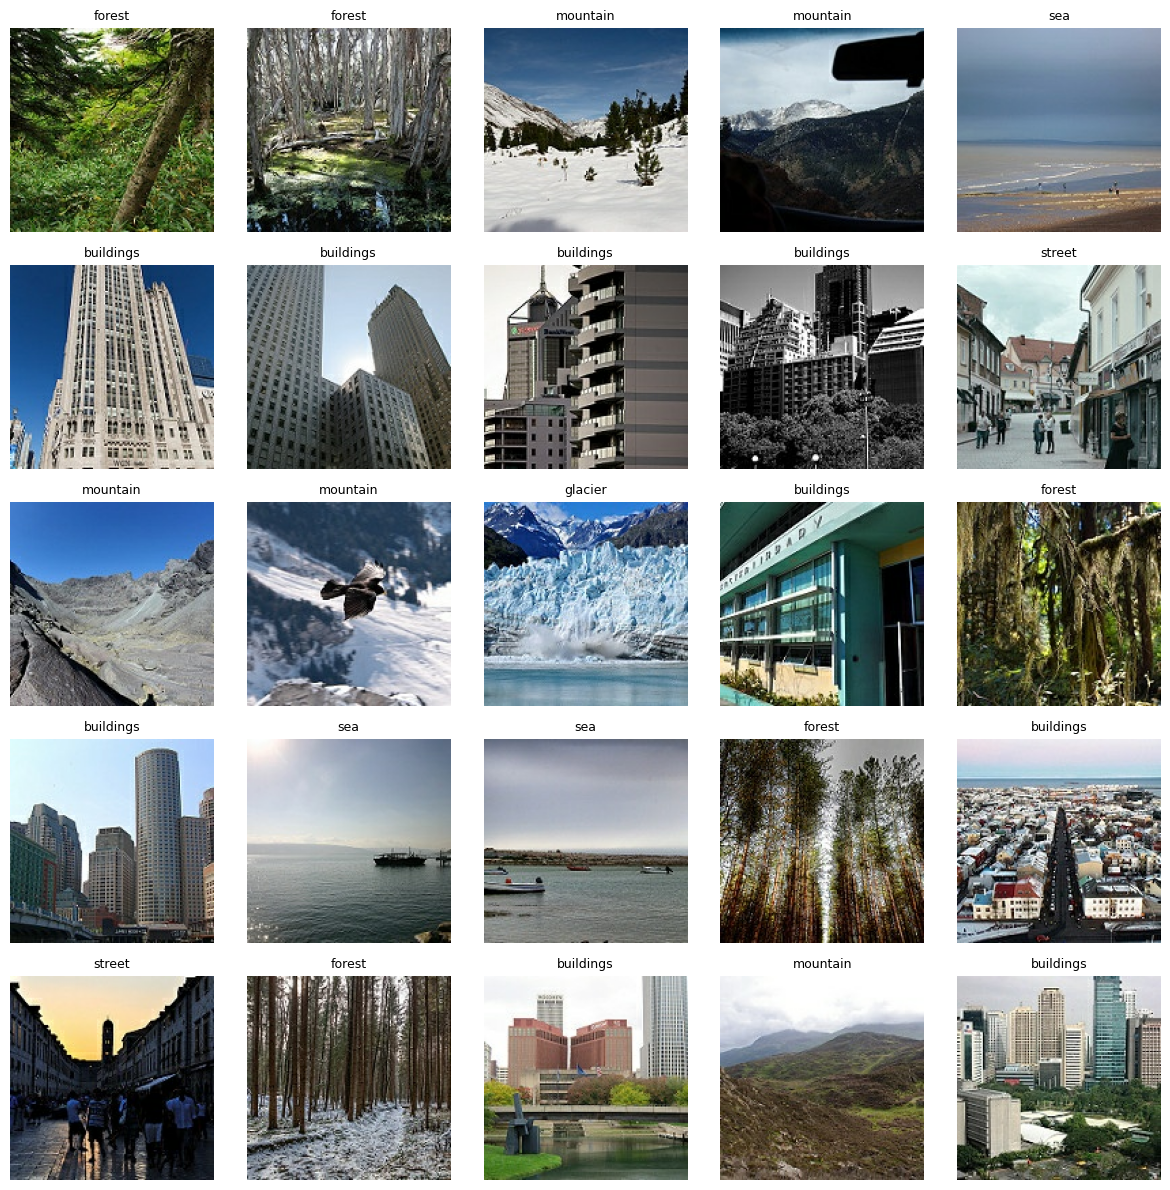

In [10]:
# Show 25 sample images

plt.figure(figsize=(12, 12))

# Take one batch from the dataset
images, labels = next(iter(train_ds))

for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[int(labels[i])], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


### Learning Rate Schedulers

In [11]:
# Must be input as callback in train_and_test(....   , callbacks=[reduce_lr] )

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-7,           # Lower bound on the learning rate.
    verbose=1,             # 0: quiet, 1: update messages.
)

### Prelude: Baseline Model

`MobileNetV2` is a lightweight, ImageNet-pretrained CNN that produces efficient, high-quality visual features.

See the **Appendix** for further information on `MobileNetV2`. 

The baseline model defined in the next cell is essentially a frozen **feature extractor** that outputs a 1280-D vector (after built-in **Global Average Pooling**).

> **NOTE:** MobileNetV2 ImageNet weights were trained at 224×224.
> We use 150×150 for faster training; this is valid because the backbone is fully convolutional
> when include_top=False (weights transfer to different input sizes).
>
> You may safely ignore the warning: "UserWarning: `input_shape` is undefined or non-square, ...."

In [12]:
# ALWAYS construct a new instance, to avoid sharing layers in multiple models

def make_base_model_pooled(trainable=False):
    base = mobilenet_v2.MobileNetV2(
        weights='imagenet', include_top=False,
        input_shape=INPUT_SHAPE, pooling='avg'
    )
    base.trainable = trainable
    return base
    
base = make_base_model_pooled()

print("Some statistics on the model:")
print("Total Keras layers:", len(base.layers))

# Count unique inverted-residual blocks by their prefix 'block_<n>'
block_ids = sorted({int(l.name.split('_')[1])
                    for l in base.layers if l.name.startswith('block_')})
print("Conv Block IDs:", block_ids, " (count:", len(block_ids), ")")

# Check if the final Conv_1 stage exists
has_conv1 = any(l.name.startswith('Conv_1') for l in base.layers)
print("Has Conv_1 stage:", has_conv1)
print('Model Output Shape:',base.output_shape)

/tmp/ipykernel_1485/966669238.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = mobilenet_v2.MobileNetV2(


Some statistics on the model:
Total Keras layers: 155
Conv Block IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]  (count: 16 )
Has Conv_1 stage: True
Model Output Shape: (None, 1280)


In [13]:
# Ha, this is very long!

# base.summary()

/tmp/ipykernel_1485/966669238.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = mobilenet_v2.MobileNetV2(



Model Baseline

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.6176 - loss: 1.0293 - val_accuracy: 0.7935 - val_loss: 0.5939
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.8485 - loss: 0.4067 - val_accuracy: 0.8478 - val_loss: 0.4115
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.8975 - loss: 0.2980 - val_accuracy: 0.8732 - val_loss: 0.3823
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9127 - loss: 0.2519 - val_accuracy: 0.8442 - val_loss: 0.3569
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9394 - loss: 0.2089 - val_accuracy: 0.8442 - val_loss: 0.3557
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9421 - loss: 0.1876 - val_accuracy: 0.8551 - val_loss: 0.3637
Epoch 7/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9510 - loss: 0.1649 - val_accuracy: 0.8623 - val_loss: 0.3497
Epoch 8/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9545 - loss: 0.1454 

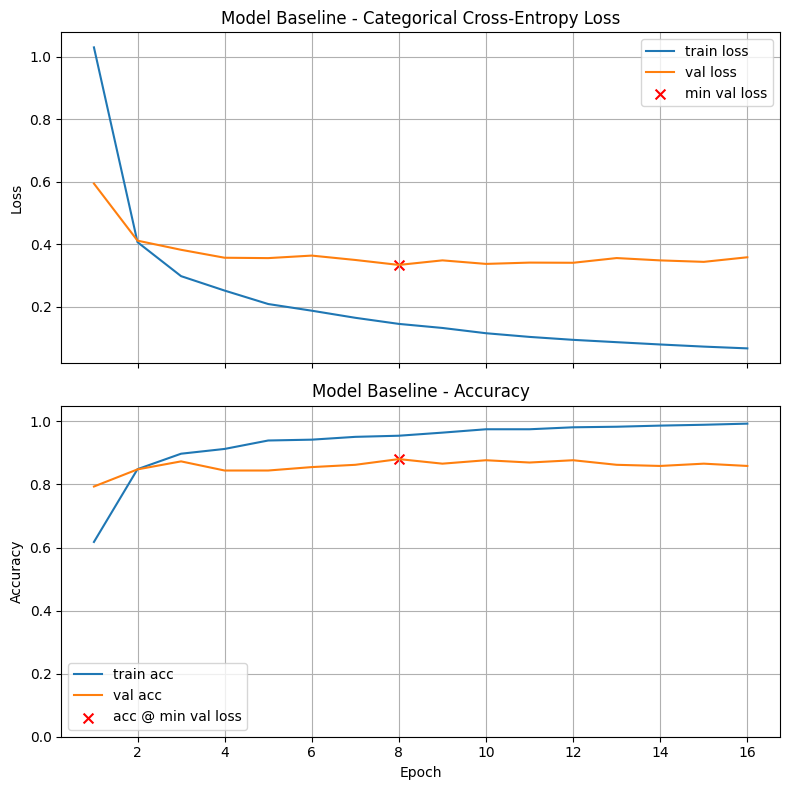

Final Training Loss:            0.0671
Final Training Accuracy:        0.9929
Final Validation Loss:          0.3584
Final Validation Accuracy:      0.8587
Minimum Validation Loss:        0.3339 (Epoch 8)
Validation Accuracy @ Min Loss: 0.8804

Test Loss: 0.3456
Test Accuracy: 0.8740

Validation-Test Gap (accuracy): 0.006435

Execution Time: 00:01:01


In [14]:
# ALWAYS construct a new instance, to avoid sharing layers in multiple models

base_model = make_base_model_pooled()

model_baseline = models.Sequential([
    base_model,
    Dense(num_classes, activation='softmax')  # use your Intel num_classes (6)
])

train_and_test(model_baseline, title="Model Baseline")

### Problem 1 — Frozen MobileNetV2 (Feature Extractor): Redesign the Head

**Goal.** Keep the MobileNetV2 backbone **frozen** and boost accuracy by modifying **only the classification head**.

**Setup.**

```python
base = make_base_pooled(trainable=False)  # MobileNetV2(include_top=False, pooling="avg")
```

This backbone already applies **Global Average Pooling** and outputs a **1280-D** feature vector per image.
Do **not** unfreeze any backbone layers and do **not** add another pooling layer.

### To Do:

1. **Ask an AI helper** (e.g., ChatGPT):
   *“What are some more complex heads that could improve this model on the Intel Image Classification Dataset, **without** unfreezing the backbone?”*
2. **Implement at least three** different head designs (they can be AI-suggested or inspired by HW4).
3. **Tune hyperparameters** for each experiment, such as:

   * **Learning-rate:** fixed LR
   * **EarlyStopping** settings
   * **Regularization:** Dropout and/or L2
   * **ReduceLROnPlateau:** on vs. off (may be combined with a fixed LR)
4. **Train and compare** the three heads.
5. **Answer the graded questions.**

### Notes / Constraints

* With `pooling="avg"`, the head receives a tensor of shape **(None, 1280)** → **do not** add `GlobalAveragePooling2D()` again.
* Using BatchNorm inside the head is fine; **do not** place BN immediately before the final softmax layer.


## 1st Head


Deep Regularized Head

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.7504 - loss: 0.8270 - val_accuracy: 0.7899 - val_loss: 0.6620 - learning_rate: 0.0010
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9082 - loss: 0.2650 - val_accuracy: 0.8514 - val_loss: 0.4852 - learning_rate: 0.0010
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9225 - loss: 0.1988 - val_accuracy: 0.8442 - val_loss: 0.4999 - learning_rate: 0.0010
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9385 - loss: 0.1576 - val_accuracy: 0.8406 - val_loss: 0.5558 - learning_rate: 0.0010
Epoch 5/500
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9728 - loss: 0.0760
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9706 - loss: 0.0814 - val_accuracy: 0.8551 - val_loss: 0.5167 - learning_rate: 0.0010
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0

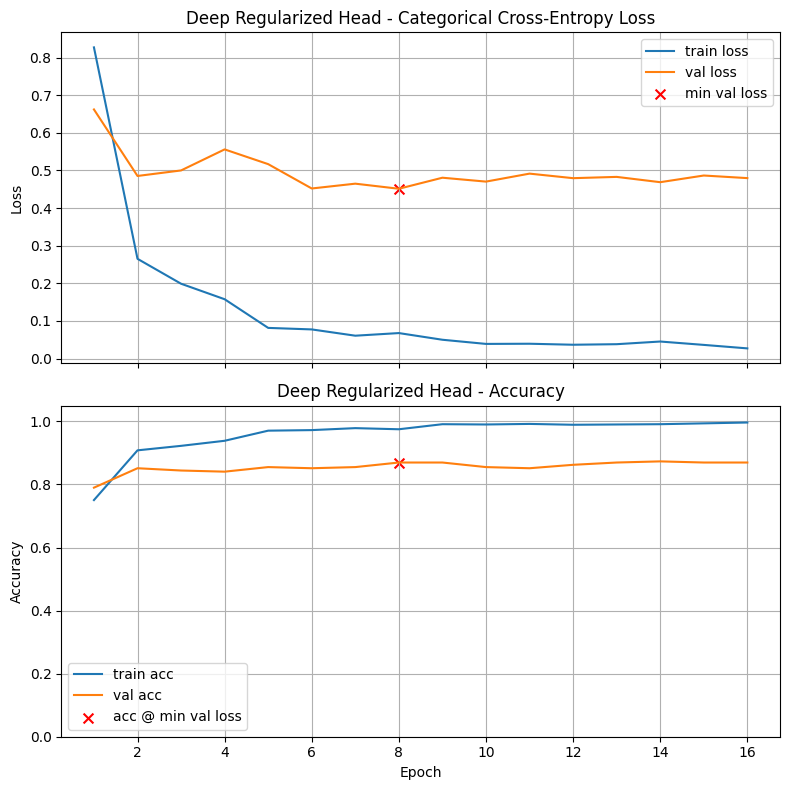

Final Training Loss:            0.0269
Final Training Accuracy:        0.9964
Final Validation Loss:          0.4795
Final Validation Accuracy:      0.8696
Minimum Validation Loss:        0.4512 (Epoch 8)
Validation Accuracy @ Min Loss: 0.8696

Test Loss: 0.4070
Test Accuracy: 0.8753

Validation-Test Gap (accuracy): 0.005768

Execution Time: 00:01:04


In [32]:
# Your code here; add as many cells as you need

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-7,           # Lower bound on the learning rate.
    verbose=1,             # 0: quiet, 1: update messages.
)

model_DeepRegular = models.Sequential([
    base_model,
    layers.Dense(512, activation='relu',name='head_dense_1'),
    layers.BatchNormalization(name='head_batchnorm'),
    layers.Dropout(0.5,name='head_dropout'),

    layers.Dense(num_classes,activation='softmax',name='predictions')
])

train_and_test(model_DeepRegular, title="Deep Regularized Head",callbacks=[reduce_lr])

## 2nd Head


Info Bottleneck

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.6078 - loss: 1.1124 - val_accuracy: 0.7464 - val_loss: 0.6682 - learning_rate: 0.0010
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.8030 - loss: 0.5659 - val_accuracy: 0.8587 - val_loss: 0.4413 - learning_rate: 0.0010
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.8512 - loss: 0.4649 - val_accuracy: 0.8841 - val_loss: 0.3495 - learning_rate: 0.0010
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.8743 - loss: 0.3869 - val_accuracy: 0.8841 - val_loss: 0.3648 - learning_rate: 0.0010
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.8984 - loss: 0.3348 - val_accuracy: 0.8804 - val_loss: 0.3614 - learning_rate: 0.0010
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9055 - loss: 0.3118 - val_accuracy: 0.8841 - val_loss: 0.3485 - learning_rate: 0.0010
Epoch 7/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.915

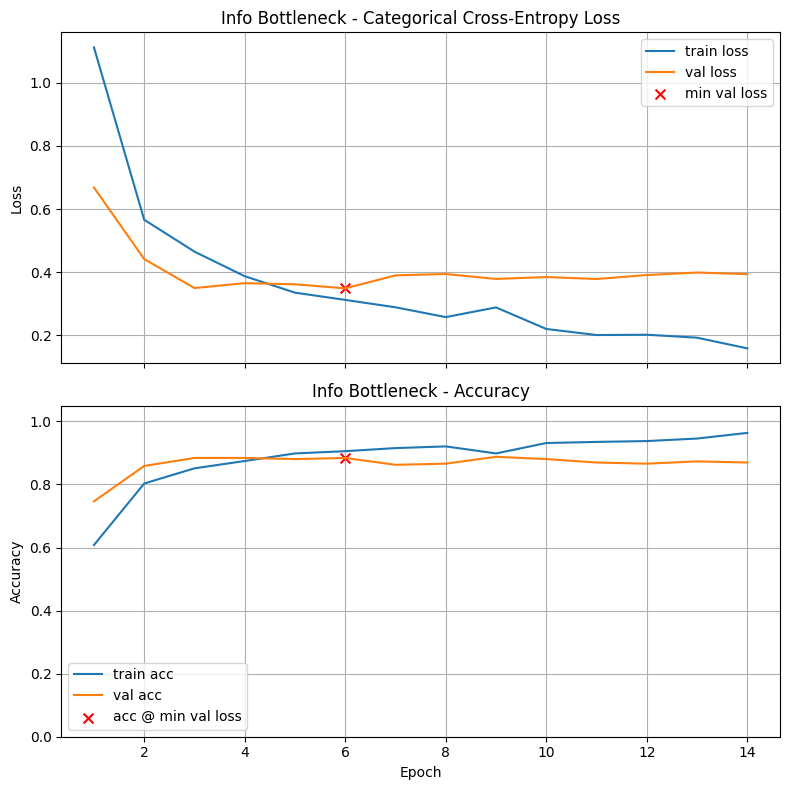

Final Training Loss:            0.1581
Final Training Accuracy:        0.9635
Final Validation Loss:          0.3935
Final Validation Accuracy:      0.8696
Minimum Validation Loss:        0.3485 (Epoch 6)
Validation Accuracy @ Min Loss: 0.8841

Test Loss: 0.3442
Test Accuracy: 0.8797

Validation-Test Gap (accuracy): 0.004391

Execution Time: 00:00:58


In [39]:
# Your code here; add as many cells as you need

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.4,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=1,             # 0: quiet, 1: update messages.
)

model_InfoBottleneck = models.Sequential([
    base_model,
    
    layers.Dense(512, activation='relu',name='bottleneck_dense_1'),
    layers.BatchNormalization(name='bottleneck_batchnorm'),
    layers.Dropout(0.5,name='bottleneck_dropout'),

    layers.Dense(128,activation='relu',name='bottleneck2_dense'),
    layers.BatchNormalization(name='bottleneck2_batchnorm'),
    layers.Dropout(0.3,name='bottleneck2_dropout'),

    layers.Dense(32,activation='relu',name='bottleneck3_dense'),
    layers.BatchNormalization(name='bottleneck3_batchnorm'),
    layers.Dropout(0.3,name='bottleneck3_dropout'),

    layers.Dense(num_classes,activation='softmax',name='predictions')
])

train_and_test(model_InfoBottleneck, title="Info Bottleneck", callbacks=[reduce_lr])

## 3rd Head


L2 Penalty

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.7674 - loss: 1.5092 - val_accuracy: 0.7935 - val_loss: 1.4216 - learning_rate: 0.0010
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9082 - loss: 0.9500 - val_accuracy: 0.8406 - val_loss: 1.2005 - learning_rate: 0.0010
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9394 - loss: 0.8366 - val_accuracy: 0.8659 - val_loss: 1.0840 - learning_rate: 0.0010
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.9688 - loss: 0.7711 - val_accuracy: 0.8478 - val_loss: 1.0792 - learning_rate: 0.0010
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.9795 - loss: 0.6998 - val_accuracy: 0.8587 - val_loss: 1.0738 - learning_rate: 0.0010
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.9822 - loss: 0.6581 - val_accuracy: 0.8768 - val_loss: 1.0679 - learning_rate: 0.0010
Epoch 7/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9866

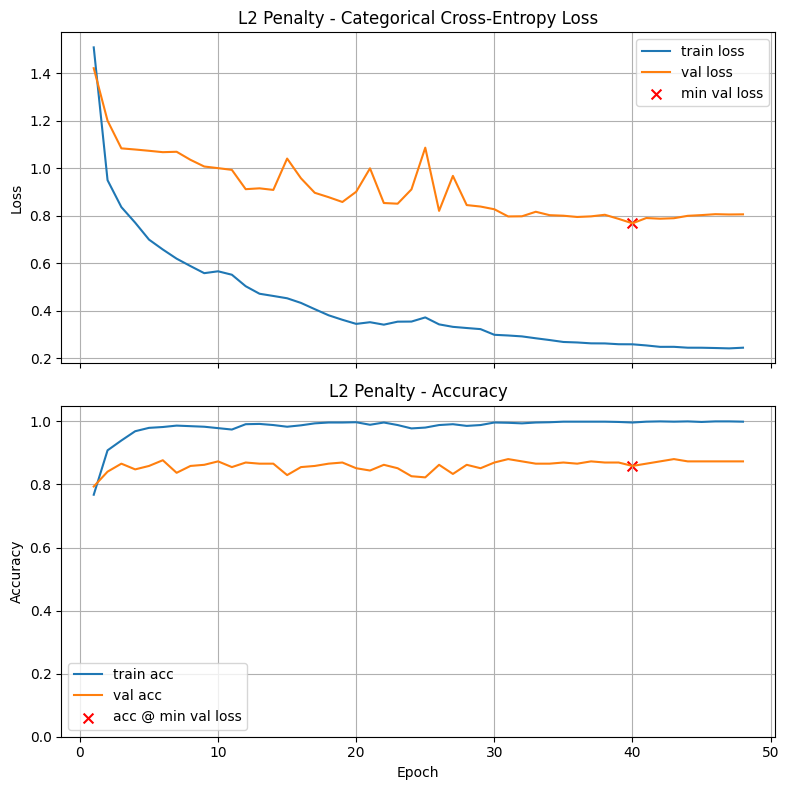

Final Training Loss:            0.2445
Final Training Accuracy:        0.9991
Final Validation Loss:          0.8061
Final Validation Accuracy:      0.8732
Minimum Validation Loss:        0.7683 (Epoch 40)
Validation Accuracy @ Min Loss: 0.8587

Test Loss: 0.7033
Test Accuracy: 0.8767

Validation-Test Gap (accuracy): 0.017971

Execution Time: 00:03:02


In [48]:
# Your code here; add as many cells as you need
from tensorflow.keras.regularizers import l2

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.4,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=1,             # 0: quiet, 1: update messages.
)

model_L2Regular = models.Sequential([
    base_model,
    
    layers.Dense(512, activation='relu',kernel_regularizer=l2(0.001),name='l2_dense_1'),
    layers.BatchNormalization(name='l2_batchnorm'),
    layers.Dropout(0.4,name='l2_dropout'),

    layers.Dense(num_classes,activation='softmax',name='predictions')
])

train_and_test(model_L2Regular, title="L2 Penalty", callbacks=[reduce_lr])

### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points. 

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when the backbone is **frozen**?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Identify the head architecture and experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when the backbone is frozen.

**Your paragraph here (5pts):**

The best-performing experiment utilized an L2-penalized classification head, featuring a 512-neuron dense layer with an L2 regularization factor of 0.001, Batch Normalization, and a 40% dropout rate. This architecture likely outperformed the baseline because the combination of L2 weight decay and aggressive dropout prevented the network from over-relying on a few dominant visual features, forcing it to learn a more balanced representation of the Intel dataset. Additionally, pairing this disciplined architecture with the ReduceLROnPlateau callback allowed the model to take large initial learning steps and then dynamically scale down the learning rate by a factor of 0.4 whenever validation loss stalled, effectively guiding the optimizer to a precise local minimum. Ultimately, this suggests that when building on top of a powerful frozen backbone, designing a head that strictly regularizes the extracted features and intelligently decays the learning rate is far more effective than simply stacking deeper layers.

**Validation Accuracy here (15 pts):**

In [49]:
# Set a1 to the validation accuracy found by your best model for this problem. 

a1 = 0.8732             # Replace 0.0 with your answer

In [50]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a1a in this problem         

print(f'a1 = {a1:.4f}') 


a1 = 0.8732


## Problem Two — Fine-tuning the Whole MobileNetV2 (Unfrozen)

**Goal.** Start from your best head from Problem 1, **unfreeze the backbone**, and fine-tune the entire model.

**Setup.** Build the base as **trainable** (it already applies Global Average Pooling and outputs a 1280-D vector—do not add another pooling layer):

```python
base = make_base_pooled(trainable=True)  # MobileNetV2(include_top=False, pooling="avg")
```

### To Do:

1. **Design at least three experiments** with the model **fully unfrozen**. Vary one or more of the following:

   * **Head choice** (select one from Problem 1).
   * **Learning-rate:** fixed LR
   * **EarlyStopping** parameters.
   * **Regularization:** Dropout and/or L2.
   * **ReduceLROnPlateau:** on vs. off (may be combined with a fixed LR).

2. **Run and compare** the three experiments **using the prototype training dataset**, focusing on:

   * training stability,
   * convergence behavior,
   * and validation performance trends.

   Use these runs to **narrow down reasonable configurations**, not to identify a single “optimal” setting.

3. **Select one configuration** and **retrain it on the full training dataset**, then use this run when answering the graded questions.

### Notes

* When fine-tuning a fully unfrozen pretrained model, it is common to use a **much smaller learning rate** (e.g., $1\times10^{-5}$ to $3\times10^{-5}$).
* Small changes in relative performance between the prototype and full dataset are expected. 


/tmp/ipykernel_1485/966669238.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = mobilenet_v2.MobileNetV2(



L2 Penalty

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.7799 - loss: 1.4273 - val_accuracy: 0.7826 - val_loss: 1.3693 - learning_rate: 0.0010
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9225 - loss: 0.9217 - val_accuracy: 0.8442 - val_loss: 1.1273 - learning_rate: 0.0010
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9439 - loss: 0.8495 - val_accuracy: 0.8514 - val_loss: 1.1165 - learning_rate: 0.0010
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9661 - loss: 0.7478 - val_accuracy: 0.8478 - val_loss: 1.1346 - learning_rate: 0.0010
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9679 - loss: 0.7127 - val_accuracy: 0.8514 - val_loss: 1.0198 - learning_rate: 0.0010
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9768 - loss: 0.6711 - val_accuracy: 0.8551 - val_loss: 1.0387 - learning_rate: 0.0010
Epoch 7/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9795 - l

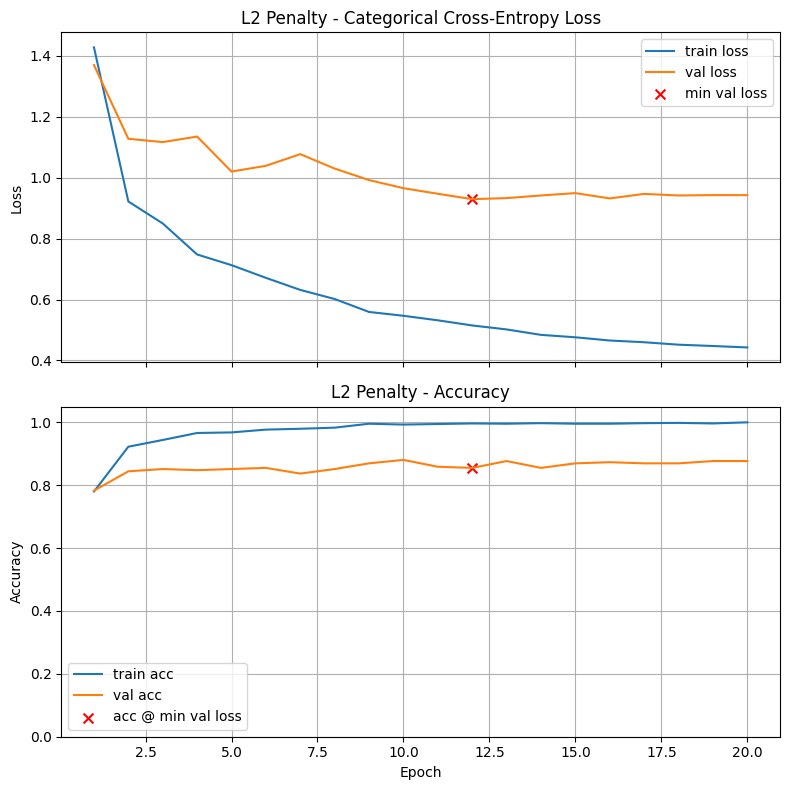

Final Training Loss:            0.4428
Final Training Accuracy:        1.0000
Final Validation Loss:          0.9424
Final Validation Accuracy:      0.8768
Minimum Validation Loss:        0.9293 (Epoch 12)
Validation Accuracy @ Min Loss: 0.8551

Test Loss: 0.9078
Test Accuracy: 0.8767

Validation-Test Gap (accuracy): 0.021594

Execution Time: 00:01:18


In [52]:
# Your code here; add as many cells as you need
base = make_base_model_pooled(trainable=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.4,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=1,             # 0: quiet, 1: update messages.
)

model_L2RegularTrainable = models.Sequential([
    base_model,
    
    layers.Dense(512, activation='relu',kernel_regularizer=l2(0.001),name='l2_dense_1'),
    layers.BatchNormalization(name='l2_batchnorm'),
    layers.Dropout(0.4,name='l2_dropout'),

    layers.Dense(num_classes,activation='softmax',name='predictions')
])

train_and_test(model_L2RegularTrainable, title="L2 Penalty", callbacks=[reduce_lr],lr_schedule=1e-3)

/tmp/ipykernel_1485/966669238.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = mobilenet_v2.MobileNetV2(



Fixed with Small LR

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.1667 - loss: 3.0575 - val_accuracy: 0.1957 - val_loss: 1.9643 - learning_rate: 1.0000e-05
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.2424 - loss: 2.4730 - val_accuracy: 0.3188 - val_loss: 1.6664 - learning_rate: 1.0000e-05
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.3146 - loss: 2.1673 - val_accuracy: 0.4710 - val_loss: 1.4221 - learning_rate: 1.0000e-05
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.3681 - loss: 1.8866 - val_accuracy: 0.5616 - val_loss: 1.2249 - learning_rate: 1.0000e-05
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.4554 - loss: 1.6424 - val_accuracy: 0.6341 - val_loss: 1.0752 - learning_rate: 1.0000e-05
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.5241 - loss: 1.3973 - val_accuracy: 0.6812 - val_loss: 0.9633 - learning_rate: 1.0000e-05
Epoch 7/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s

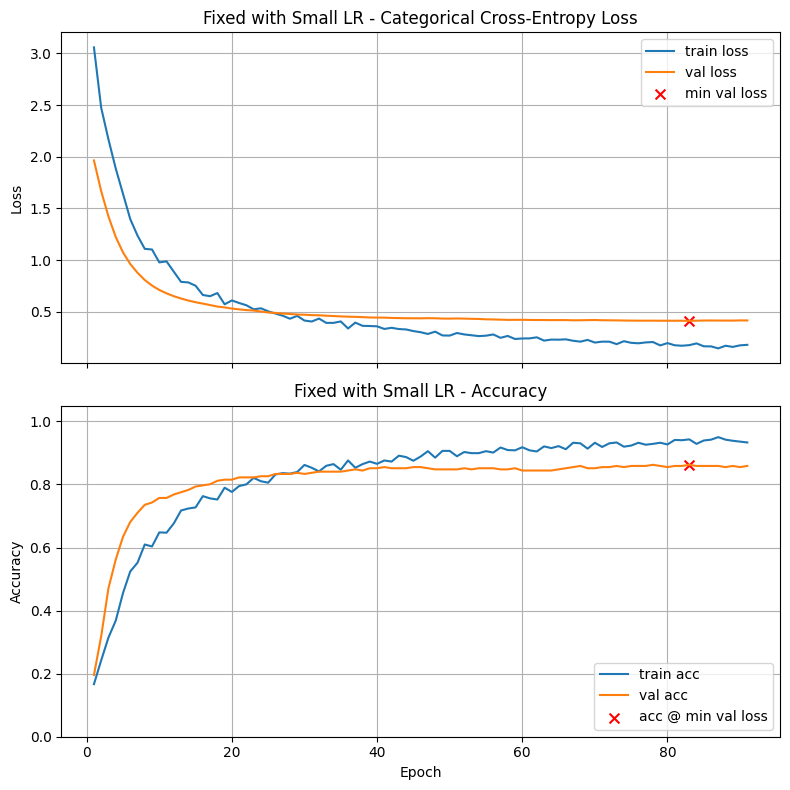

Final Training Loss:            0.1813
Final Training Accuracy:        0.9332
Final Validation Loss:          0.4172
Final Validation Accuracy:      0.8587
Minimum Validation Loss:        0.4133 (Epoch 83)
Validation Accuracy @ Min Loss: 0.8623

Test Loss: 0.3920
Test Accuracy: 0.8677

Validation-Test Gap (accuracy): 0.005348

Execution Time: 00:05:17


In [53]:
# Your code here; add as many cells as you need
base = make_base_model_pooled(trainable=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.4,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=1,             # 0: quiet, 1: update messages.
)

model_FixedTrainable = models.Sequential([
    base_model,
    
    layers.Dense(512, activation='relu',name='fixed_dense_1'),
    layers.BatchNormalization(name='fixed_batchnorm'),
    layers.Dropout(0.5,name='fixed_dropout'),

    layers.Dense(num_classes,activation='softmax',name='predictions')
])

train_and_test(model_FixedTrainable, title="Fixed with Small LR", callbacks=[reduce_lr],lr_schedule=1e-5)

/tmp/ipykernel_1485/966669238.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = mobilenet_v2.MobileNetV2(



More Layers

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - accuracy: 0.2317 - loss: 2.2224 - val_accuracy: 0.3225 - val_loss: 1.5745 - learning_rate: 1.0000e-04
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.4216 - loss: 1.5387 - val_accuracy: 0.6268 - val_loss: 1.1790 - learning_rate: 1.0000e-04
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.5588 - loss: 1.2227 - val_accuracy: 0.7246 - val_loss: 0.9251 - learning_rate: 1.0000e-04
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.6132 - loss: 1.0484 - val_accuracy: 0.7645 - val_loss: 0.7581 - learning_rate: 1.0000e-04
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.6774 - loss: 0.8862 - val_accuracy: 0.8007 - val_loss: 0.6739 - learning_rate: 1.0000e-04
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.7193 - loss: 0.8042 - val_accuracy: 0.8225 - val_loss: 0.6221 - learning_rate: 1.0000e-04
Epoch 7/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/st

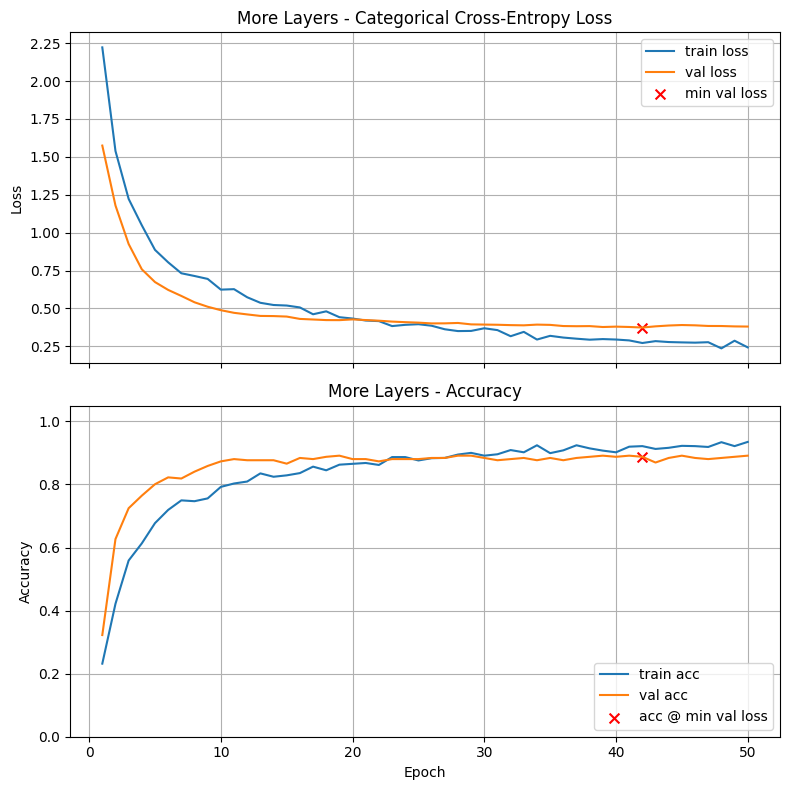

Final Training Loss:            0.2429
Final Training Accuracy:        0.9349
Final Validation Loss:          0.3802
Final Validation Accuracy:      0.8913
Minimum Validation Loss:        0.3738 (Epoch 42)
Validation Accuracy @ Min Loss: 0.8877

Test Loss: 0.3555
Test Accuracy: 0.8777

Validation-Test Gap (accuracy): 0.010015

Execution Time: 00:03:08


In [54]:
# Your code here; add as many cells as you need
base = make_base_model_pooled(trainable=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.4,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=1,             # 0: quiet, 1: update messages.
)

model_MoreLayersTrainable = models.Sequential([
    base_model,
    
    layers.Dense(512, activation='relu',name='more_dense_1'),
    layers.BatchNormalization(name='more_batchnorm'),
    layers.Dropout(0.4,name='more_dropout'),

    layers.Dense(128,activation='relu',name='more2_dense'),
    layers.BatchNormalization(name='more2_batchnorm'),
    layers.Dropout(0.3,name='more2_dropout'),

    layers.Dense(32,activation='relu',name='more3_dense'),
    layers.BatchNormalization(name='more3_batchnorm'),
    layers.Dropout(0.3,name='more3_dropout'),

    layers.Dense(num_classes,activation='softmax',name='predictions')
])

train_and_test(model_MoreLayersTrainable, title="More Layers", callbacks=[reduce_lr],lr_schedule=1e-4)

### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points. 

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when the backbone is **unfrozen**?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when the backbone is unfrozen.

**Your paragraph here (5 pts):**





For this problem I decided to replicate most of the designs that I had in the first problem. All three of the heads in the first problem had very similar validation accuracies and any given head could nearly out perform the other when ran. The multiple layer approach seemed to perform the best this time by a decent margin (~0.02). Creating the 3-stage funnel approach from 512 to 128 to 32 likely forced the network to systematically disregard useless background noise. When the backbone is unfrozen there is a higher likelihood of overfitting the data rather than learning general patterns. By 2 BatchNormalizations and Dropout after every single layer, this seemed to curtail memorizing the training data.

**Validation accuracy here (15 pts):**

In [55]:
# Set a2 to the validation accuracy found by your best model for this problem. 

a2 = 0.8913             # Replace 0.0 with your answer

In [56]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a1a in this problem       

print(f'a2 = {a2:.4f}') 

a2 = 0.8913


## Problem Three — Unfreezing Layers

**Goal.** Keep most of the backbone frozen and **unfreeze only the last $N$ layers** to fine-tune.
(In Problem 4 you’ll explore unfreezing the top **K MobileNetV2 blocks** instead.)

**Setup.** Your backbone is **MobileNetV2** with `include_top=False, pooling="avg"` (so it outputs a 1280-D vector). Do **not** add another pooling layer in the head.

After creating the model, unfreeze the top $N$ layers using the following approach:

```python
N = 20
model = make_base_model_pooled()
base_model.trainable = True
for layer in base_model.layers[:-N]:
    layer.trainable = False
```

### To Do:

1. **Design at least three experiments** with the model having the **last $N$ layers unfrozen**. Vary one or more of the following:

   * $N \in {20, 40, 80}$
   * **Head choice** (select one from Problem 1).
   * **Learning-rate:** fixed LR
   * **EarlyStopping** parameters.
   * **Regularization:** Dropout and/or L2.
   * **ReduceLROnPlateau:** on vs. off (may be combined with a fixed LR).

2. **Run and compare** the three experiments **using the prototype training dataset**, focusing on:

   * how performance changes as more layers are unfrozen,
   * training stability and convergence,
   * and validation performance trends.

   Use these runs to **understand the effect of partial unfreezing**, not to identify a single globally optimal configuration.

3. **Select one configuration** (choice of $N$ and training strategy) and **retrain it on the full training dataset**, then use this run when answering the graded questions.

### Notes

* As more layers are unfrozen, the model typically becomes **more sensitive to learning rate**.
* Learning rates in the range of approximately $1\times10^{-5}$ to $3\times10^{-5}$ are often appropriate for partial fine-tuning, but experimentation is encouraged.
* Small shifts in relative performance between the prototype and full dataset are expected.


In [ ]:
# Your code here; add as many cells as you need

N = 20
model = make_base_model_pooled()
base_model.trainable = True
for layer in base_model.layers[:-N]:
    layer.trainable = False

/tmp/ipykernel_1485/966669238.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = mobilenet_v2.MobileNetV2(



20 Unfrozen

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.3324 - loss: 1.8871 - val_accuracy: 0.4529 - val_loss: 1.3049 - learning_rate: 1.0000e-04
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.4964 - loss: 1.3245 - val_accuracy: 0.5725 - val_loss: 1.0536 - learning_rate: 1.0000e-04
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.5633 - loss: 1.1010 - val_accuracy: 0.6558 - val_loss: 0.8914 - learning_rate: 1.0000e-04
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.6275 - loss: 0.9714 - val_accuracy: 0.6630 - val_loss: 0.7927 - learning_rate: 1.0000e-04
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.6693 - loss: 0.8374 - val_accuracy: 0.6957 - val_loss: 0.7415 - learning_rate: 1.0000e-04
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.7237 - loss: 0.7340 - val_accuracy: 0.7355 - val_loss: 0.7000 - learning_rate: 1.0000e-04
Epoch 7/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 1

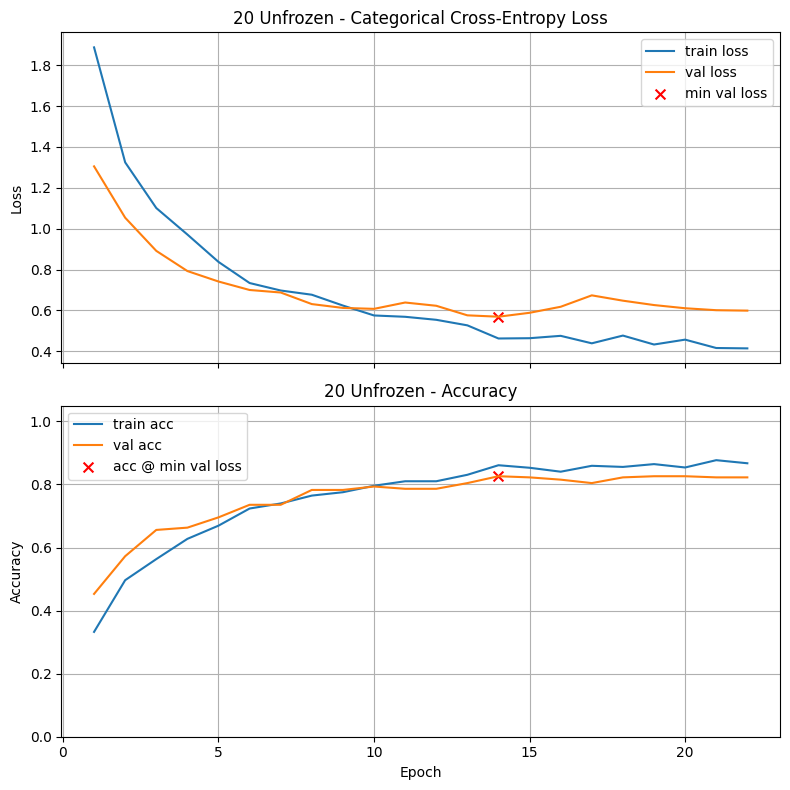

Final Training Loss:            0.4143
Final Training Accuracy:        0.8672
Final Validation Loss:          0.5990
Final Validation Accuracy:      0.8225
Minimum Validation Loss:        0.5693 (Epoch 14)
Validation Accuracy @ Min Loss: 0.8261

Test Loss: 0.5121
Test Accuracy: 0.8200

Validation-Test Gap (accuracy): 0.006087

Execution Time: 00:01:42


In [58]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.4,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=1,             # 0: quiet, 1: update messages.
)

model_twenty = models.Sequential([
    base_model,
    
    layers.Dense(512, activation='relu',name='twenty_dense_1'),
    layers.BatchNormalization(name='twenty_batchnorm'),
    layers.Dropout(0.4,name='twenty_dropout'),

    layers.Dense(128,activation='relu',name='twenty2_dense'),
    layers.BatchNormalization(name='twenty2_batchnorm'),
    layers.Dropout(0.3,name='twenty2_dropout'),

    layers.Dense(32,activation='relu',name='twenty3_dense'),
    layers.BatchNormalization(name='twenty3_batchnorm'),
    layers.Dropout(0.3,name='twenty3_dropout'),

    layers.Dense(num_classes,activation='softmax',name='predictions')
])

train_and_test(model_twenty, title="20 Unfrozen", callbacks=[reduce_lr],lr_schedule=1e-4)

/tmp/ipykernel_1485/966669238.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = mobilenet_v2.MobileNetV2(



20 Unfrozen

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.1943 - loss: 2.3250 - val_accuracy: 0.2536 - val_loss: 1.9541 - learning_rate: 1.0000e-05
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.2433 - loss: 2.1380 - val_accuracy: 0.3152 - val_loss: 1.7534 - learning_rate: 1.0000e-05
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.2576 - loss: 1.9778 - val_accuracy: 0.3370 - val_loss: 1.6078 - learning_rate: 1.0000e-05
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.3271 - loss: 1.8107 - val_accuracy: 0.3877 - val_loss: 1.4818 - learning_rate: 1.0000e-05
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.3360 - loss: 1.7432 - val_accuracy: 0.4384 - val_loss: 1.3921 - learning_rate: 1.0000e-05
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.3592 - loss: 1.6642 - val_accuracy: 0.4819 - val_loss: 1.3032 - learning_rate: 1.0000e-05
Epoch 7/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 11

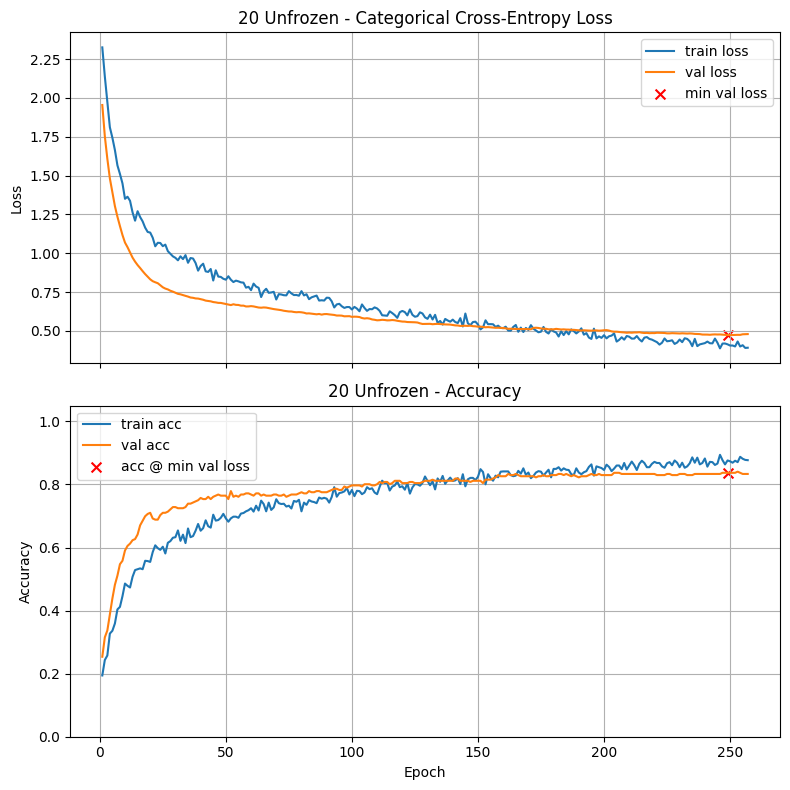

Final Training Loss:            0.3917
Final Training Accuracy:        0.8770
Final Validation Loss:          0.4796
Final Validation Accuracy:      0.8333
Minimum Validation Loss:        0.4733 (Epoch 249)
Validation Accuracy @ Min Loss: 0.8370

Test Loss: 0.4348
Test Accuracy: 0.8587

Validation-Test Gap (accuracy): 0.021710

Execution Time: 00:17:36


In [ ]:
N = 40
model = make_base_model_pooled()
base_model.trainable = True
for layer in base_model.layers[:-N]:
    layer.trainable = False

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=1,             # 0: quiet, 1: update messages.
)

model_twenty = models.Sequential([
    base_model,
    
    layers.Dense(512, activation='relu',name='twenty_dense_1'),
    layers.BatchNormalization(name='twenty_batchnorm'),
    layers.Dropout(0.5,name='twenty_dropout'),

    layers.Dense(128,activation='relu',name='twenty2_dense'),
    layers.BatchNormalization(name='twenty2_batchnorm'),
    layers.Dropout(0.3,name='twenty2_dropout'),

    layers.Dense(32,activation='relu',name='twenty3_dense'),
    layers.BatchNormalization(name='twenty3_batchnorm'),
    layers.Dropout(0.2,name='twenty3_dropout'),

    layers.Dense(num_classes,activation='softmax',name='predictions')
])

train_and_test(model_twenty, title="40 Unfrozen", callbacks=[reduce_lr],lr_schedule=1e-5)

/tmp/ipykernel_1485/966669238.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = mobilenet_v2.MobileNetV2(



80 Unfrozen

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.3182 - loss: 1.9851 - val_accuracy: 0.6703 - val_loss: 1.1452 - learning_rate: 1.0000e-04
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.5784 - loss: 1.1432 - val_accuracy: 0.8080 - val_loss: 0.7964 - learning_rate: 1.0000e-04
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.6943 - loss: 0.8757 - val_accuracy: 0.8261 - val_loss: 0.6810 - learning_rate: 1.0000e-04
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7228 - loss: 0.7838 - val_accuracy: 0.8333 - val_loss: 0.6000 - learning_rate: 1.0000e-04
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7683 - loss: 0.7005 - val_accuracy: 0.8478 - val_loss: 0.5458 - learning_rate: 1.0000e-04
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7950 - loss: 0.5958 - val_accuracy: 0.8551 - val_loss: 0.5273 - learning_rate: 1.0000e-04
Epoch 7/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 11

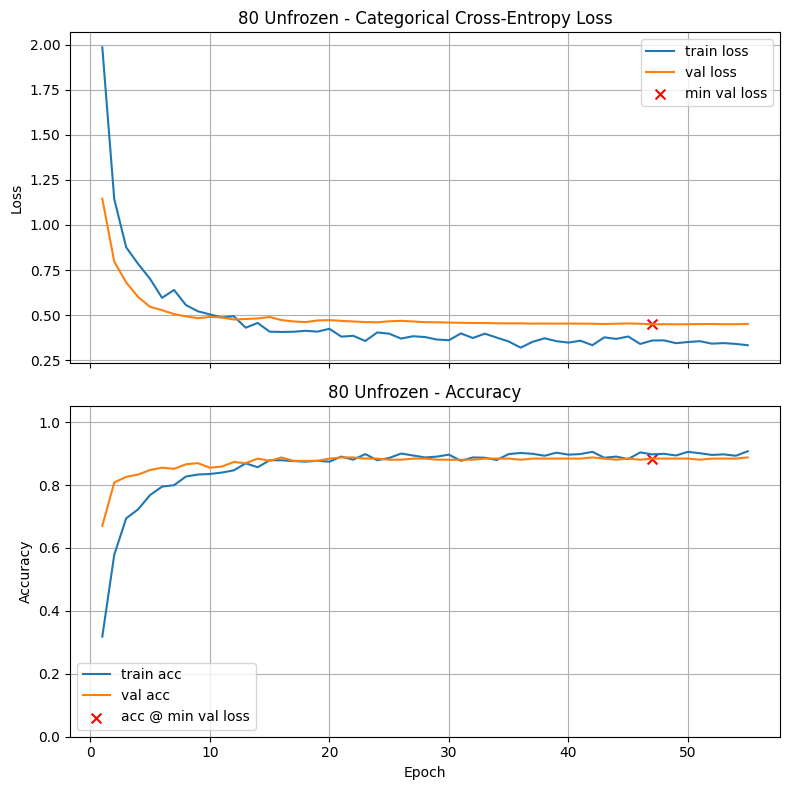

Final Training Loss:            0.3328
Final Training Accuracy:        0.9073
Final Validation Loss:          0.4511
Final Validation Accuracy:      0.8877
Minimum Validation Loss:        0.4491 (Epoch 47)
Validation Accuracy @ Min Loss: 0.8841

Test Loss: 0.4010
Test Accuracy: 0.8737

Validation-Test Gap (accuracy): 0.010391

Execution Time: 00:03:57


In [60]:
N = 80
model = make_base_model_pooled()
base_model.trainable = True
for layer in base_model.layers[:-N]:
    layer.trainable = False

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.4,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=1,             # 0: quiet, 1: update messages.
)

model_eighty = models.Sequential([
    base_model,
    
    layers.Dense(512, activation='relu',name='eighty_dense_1'),
    layers.BatchNormalization(name='eighty_batchnorm'),
    layers.Dropout(0.5,name='eighty_dropout'),

    layers.Dense(128,activation='relu',name='eighty2_dense'),
    layers.BatchNormalization(name='eighty2_batchnorm'),
    layers.Dropout(0.3,name='eighty2_dropout'),

    layers.Dense(32,activation='relu',name='eighty3_dense'),
    layers.BatchNormalization(name='eighty3_batchnorm'),
    layers.Dropout(0.3,name='eighty3_dropout'),

    layers.Dense(num_classes,activation='softmax',name='predictions')
])

train_and_test(model_eighty, title="80 Unfrozen", callbacks=[reduce_lr],lr_schedule=1e-4)

### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points. 

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when you have unfrozen some number N of layers?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., **number N of unfrozen layers,** dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when you have unfrozen some number of layers?

**Your paragraph here (5pts):**




To systematically explore the trade-off between retaining generalized ImageNet weights and learning dataset-specific visual patterns, I designed three experiments that progressively unfroze deeper sections of the backbone ($N=20, 40, 80$) while adjusting learning rates and dropout to manage the growing parameter count. The experiment unfreezing the last 80 layers ($N=80$) performed the best, achieving a strong validation accuracy of 0.8877. This deeper unfreeze likely outperformed the shallower $N=20$ and $N=40$ models because it gave the network the flexibility to significantly adapt its core feature extraction to the dataset, while the deep, three-stage bottleneck head (512 $\rightarrow$ 128 $\rightarrow$ 32), aggressive dropout layers, and ReduceLROnPlateau callback worked seamlessly together to stabilize gradients and prevent the newly unfrozen weights from overfitting. Ultimately, this suggests that as you unfreeze a larger number of layers in a pre-trained backbone, your classification head must rely on increasingly disciplined, multi-stage regularization and dynamic learning rate decay to safely guide the model to convergence.

**Validation accuracy here (15 pts):**

In [61]:
# Set a3 to the validation accuracy found by your best model for this problem. 

a3 = 0.8877           # Replace 0.0 with your answer

In [62]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3 = {a3:.4f}') 

a3 = 0.8877


## Problem Four — Unfreezing Convolution Blocks

**Goal.** Fine-tune MobileNetV2 by unfreezing the **last $K$ convolutional stages/blocks** (rather than unfreezing the last $N$ individual layers as in Problem 3). This gives you a more “semantic” way to control how much of the backbone adapts.

**Setup.** Your backbone is MobileNetV2 with `include_top=False, pooling="avg"` (so it outputs a 1280-D vector). Do **not** add another pooling layer in the head.

After creating a model, unfreeze the top $K$ blocks using the following approach:

```python
block_prefixes = [
    'block_1', 'block_2', 'block_3', 'block_4',
    'block_5', 'block_6', 'block_7', 'block_8',
    'block_9', 'block_10', 'block_11', 'block_12',
    'block_13', 'block_14', 'block_15', 'block_16',
    'Conv_1',   # final 1×1 conv stage before pooling
]

K = 3

model = make_base_model_pooled(trainable=False)

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        # Often recommended to keep BN frozen during fine-tuning
        layer.trainable = False
    else:
        layer.trainable = any(layer.name.startswith(p) for p in block_prefixes[-K:])
```

### To Do:

1. **Design at least three experiments** with the model having the **last $K$ stages unfrozen**. Vary one or more of the following:

   * $K \in {1, 2, 3, 5}$ *(K counts stages/blocks, not individual layers)*
   * **BatchNormalization strategy:** keep BN frozen vs. unfreeze BN.
   * **Head choice** (select one from Problem 1).
   * **Learning-rate:** fixed LR
   * **EarlyStopping** parameters.
   * **Regularization:** Dropout and/or L2.
   * **ReduceLROnPlateau:** on vs. off (may be combined with a fixed LR).

2. **Run and compare** the experiments **using the prototype training dataset**, focusing on:

   * how performance changes as more blocks are unfrozen,
   * whether unfreezing BN helps or destabilizes training,
   * and validation performance trends and stability.

   Use these runs to **understand the effect of block-level fine-tuning** and to narrow down reasonable configurations.

3. **Select one configuration** (choice of $K$, BN strategy, and training strategy) and **retrain it on the full training dataset**, then use this run when answering the graded questions.

### Notes

* Your backbone was built with `pooling="avg"` → **do not** add another `GlobalAveragePooling2D()`.
* Unfreezing more blocks usually requires a **smaller learning rate** and can increase training instability; this is part of what you are investigating.
* Small shifts in relative performance between the prototype and full dataset are expected.


In [63]:
block_prefixes = [
    'block_1', 'block_2', 'block_3', 'block_4',
    'block_5', 'block_6', 'block_7', 'block_8',
    'block_9', 'block_10', 'block_11', 'block_12',
    'block_13', 'block_14', 'block_15', 'block_16',
    'Conv_1', 
]

reduce_lr_blocks = ReduceLROnPlateau(
    monitor='val_loss', factor=0.4, patience=3, min_delta=1e-4, 
    cooldown=0, min_lr=1e-6, verbose=1
)

def build_block_unfrozen_model(K, unfreeze_bn=False, name_prefix=""):
    """Builds the model unfreezing the last K blocks, with a toggle for BN layers."""
    base = make_base_model_pooled(trainable=False)

    for layer in base.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = unfreeze_bn
        else:

            layer.trainable = any(layer.name.startswith(p) for p in block_prefixes[-K:])

    model = models.Sequential([
        base,
        layers.Dense(512, activation='relu', name=f'{name_prefix}_dense_1'),
        layers.BatchNormalization(name=f'{name_prefix}_batchnorm_1'),
        layers.Dropout(0.5, name=f'{name_prefix}_drop_1'),

        layers.Dense(128, activation='relu', name=f'{name_prefix}_dense_2'),
        layers.BatchNormalization(name=f'{name_prefix}_batchnorm_2'),
        layers.Dropout(0.3, name=f'{name_prefix}_drop_2'),

        layers.Dense(32, activation='relu', name=f'{name_prefix}_dense_3'),
        layers.BatchNormalization(name=f'{name_prefix}_batchnorm_3'),
        layers.Dropout(0.3, name=f'{name_prefix}_drop_3'),

        layers.Dense(num_classes, activation='softmax', name='predictions')
    ])
    return model

/tmp/ipykernel_1485/966669238.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = mobilenet_v2.MobileNetV2(



Exp 1: K=1 Block (BN Frozen)

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.2718 - loss: 2.2043 - val_accuracy: 0.5036 - val_loss: 1.3333 - learning_rate: 1.0000e-04
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.5303 - loss: 1.3158 - val_accuracy: 0.6920 - val_loss: 0.9376 - learning_rate: 1.0000e-04
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.6212 - loss: 1.0556 - val_accuracy: 0.7754 - val_loss: 0.7059 - learning_rate: 1.0000e-04
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.6765 - loss: 0.8962 - val_accuracy: 0.8261 - val_loss: 0.6001 - learning_rate: 1.0000e-04
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.7130 - loss: 0.7983 - val_accuracy: 0.8370 - val_loss: 0.5399 - learning_rate: 1.0000e-04
Epoch 6/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.7469 - loss: 0.7005 - val_accuracy: 0.8478 - val_loss: 0.5045 - learning_rate: 1.0000e-04
Epoch 7/500
36/36 ━━━━━━━━━━━━

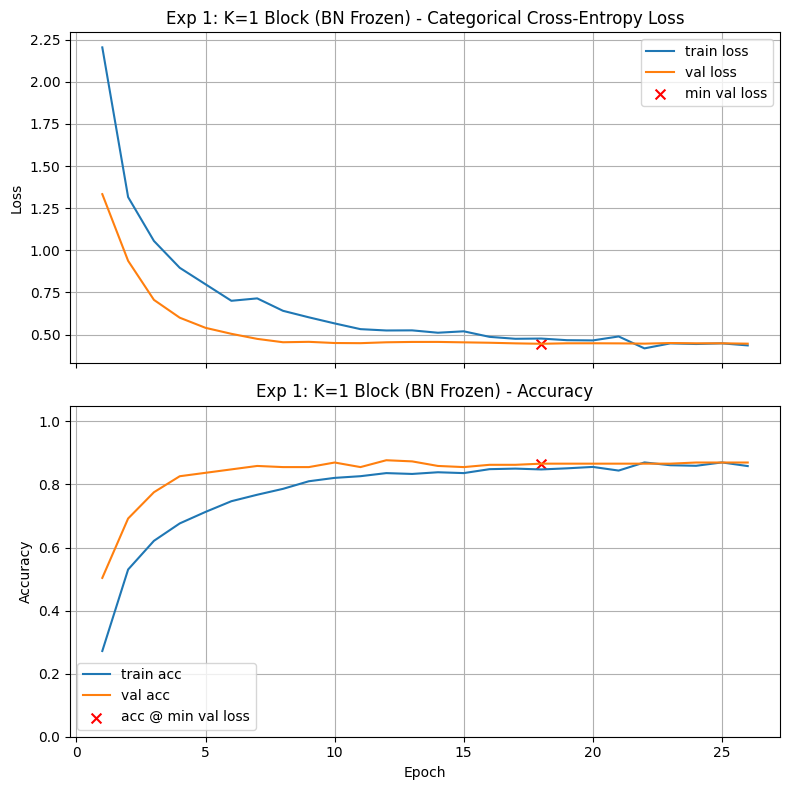

Final Training Loss:            0.4357
Final Training Accuracy:        0.8583
Final Validation Loss:          0.4460
Final Validation Accuracy:      0.8696
Minimum Validation Loss:        0.4453 (Epoch 18)
Validation Accuracy @ Min Loss: 0.8659

Test Loss: 0.3947
Test Accuracy: 0.8753

Validation-Test Gap (accuracy): 0.009391

Execution Time: 00:01:43


In [64]:
model_K1_frozen = build_block_unfrozen_model(K=1, unfreeze_bn=False, name_prefix="k1")
train_and_test(
    model_K1_frozen, 
    title="Exp 1: K=1 Block (BN Frozen)", 
    lr_schedule=1e-4,
    callbacks=[reduce_lr_blocks]
)

/tmp/ipykernel_1485/966669238.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = mobilenet_v2.MobileNetV2(



Exp 2: K=3 Blocks (BN Frozen)

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.2540 - loss: 2.2080 - val_accuracy: 0.4130 - val_loss: 1.4107 - learning_rate: 3.0000e-05
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.4002 - loss: 1.7116 - val_accuracy: 0.5616 - val_loss: 1.1429 - learning_rate: 3.0000e-05
Epoch 3/500
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4505 - loss: 1.4452
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.1999999696854503e-05.
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.4572 - loss: 1.4652 - val_accuracy: 0.6051 - val_loss: 1.0389 - learning_rate: 3.0000e-05
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.5071 - loss: 1.3314 - val_accuracy: 0.6123 - val_loss: 0.9769 - learning_rate: 1.2000e-05
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.5178 - loss: 1.3171 - val_accuracy: 0.6703 - val_loss: 0.8945 - learning_rate: 1.2000e-05
Epoch 6/500
35/36 ━━━━━━━━━━━━━━

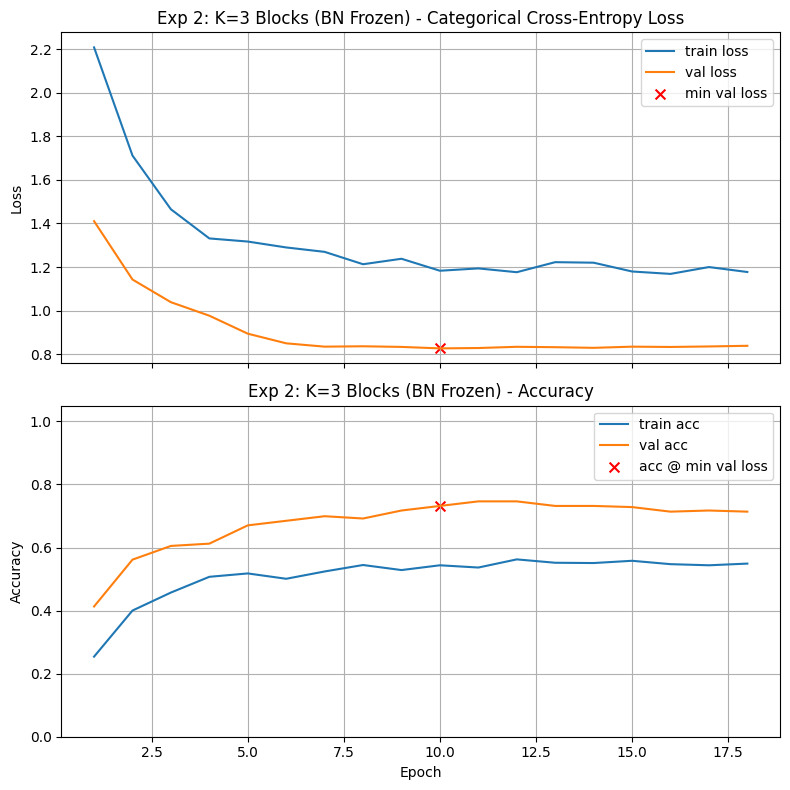

Final Training Loss:            1.1774
Final Training Accuracy:        0.5490
Final Validation Loss:          0.8389
Final Validation Accuracy:      0.7138
Minimum Validation Loss:        0.8270 (Epoch 10)
Validation Accuracy @ Min Loss: 0.7319

Test Loss: 0.8646
Test Accuracy: 0.7150

Validation-Test Gap (accuracy): 0.016884

Execution Time: 00:01:19


In [65]:
model_K3_frozen = build_block_unfrozen_model(K=3, unfreeze_bn=False, name_prefix="k3_f")
train_and_test(
    model_K3_frozen, 
    title="Exp 2: K=3 Blocks (BN Frozen)", 
    lr_schedule=3e-5,
    callbacks=[reduce_lr_blocks]
)

/tmp/ipykernel_1485/966669238.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = mobilenet_v2.MobileNetV2(



Exp 3: K=3 Blocks (BN UNFROZEN)

Epoch 1/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 377ms/step - accuracy: 0.1756 - loss: 2.4659 - val_accuracy: 0.1884 - val_loss: 2.0213 - learning_rate: 3.0000e-05
Epoch 2/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 349ms/step - accuracy: 0.2175 - loss: 2.3308 - val_accuracy: 0.2246 - val_loss: 1.7940 - learning_rate: 3.0000e-05
Epoch 3/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.2626 - loss: 2.0961
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.1999999696854503e-05.
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 342ms/step - accuracy: 0.2656 - loss: 2.1067 - val_accuracy: 0.3080 - val_loss: 1.6592 - learning_rate: 3.0000e-05
Epoch 4/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 339ms/step - accuracy: 0.2674 - loss: 2.0250 - val_accuracy: 0.3551 - val_loss: 1.6118 - learning_rate: 1.2000e-05
Epoch 5/500
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 341ms/step - accuracy: 0.2701 - loss: 2.0076 - val_accuracy: 0.4058 - val_loss: 1.5540 - learning_rate: 1.2000e-05
Epoch 6/500
36/36 ━━━━━━

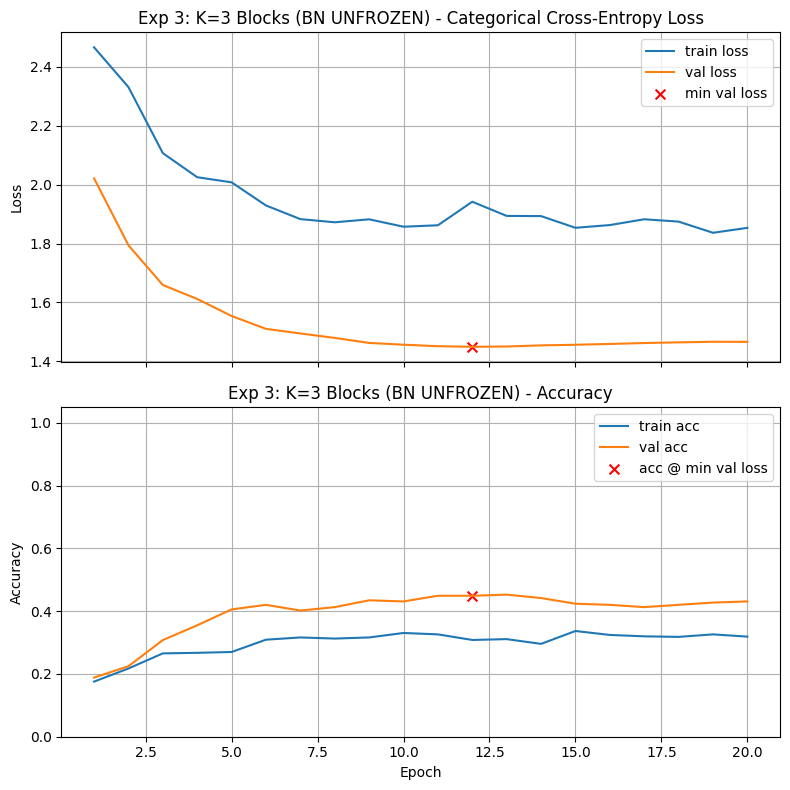

Final Training Loss:            1.8532
Final Training Accuracy:        0.3191
Final Validation Loss:          1.4663
Final Validation Accuracy:      0.4312
Minimum Validation Loss:        1.4494 (Epoch 12)
Validation Accuracy @ Min Loss: 0.4493

Test Loss: 1.4417
Test Accuracy: 0.4460

Validation-Test Gap (accuracy): 0.003275

Execution Time: 00:04:27


In [66]:
model_K3_unfrozen = build_block_unfrozen_model(K=3, unfreeze_bn=True, name_prefix="k3_u")
train_and_test(
    model_K3_unfrozen, 
    title="Exp 3: K=3 Blocks (BN UNFROZEN)", 
    lr_schedule=3e-5, 
    callbacks=[reduce_lr_blocks]
)

/tmp/ipykernel_1485/966669238.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = mobilenet_v2.MobileNetV2(



FINAL RUN: K=3 Blocks Full Dataset

Epoch 1/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.4037 - loss: 1.7561 - val_accuracy: 0.3804 - val_loss: 1.3403 - learning_rate: 1.0000e-04
Epoch 2/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.5365 - loss: 1.2391 - val_accuracy: 0.6775 - val_loss: 0.8355 - learning_rate: 1.0000e-04
Epoch 3/25
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5892 - loss: 1.1050
Epoch 3: ReduceLROnPlateau reducing learning rate to 3.9999998989515007e-05.
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.5856 - loss: 1.1011 - val_accuracy: 0.6558 - val_loss: 0.9311 - learning_rate: 1.0000e-04
Epoch 4/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.6034 - loss: 1.0650 - val_accuracy: 0.8116 - val_loss: 0.6093 - learning_rate: 4.0000e-05
Epoch 5/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.6524 - loss: 0.9678 - val_accuracy: 0.8297 - val_loss: 0.5230 - learning_rate: 4.0000e-05
Epoch 6/25
35/36 ━━━━━━━━━━━━━━━

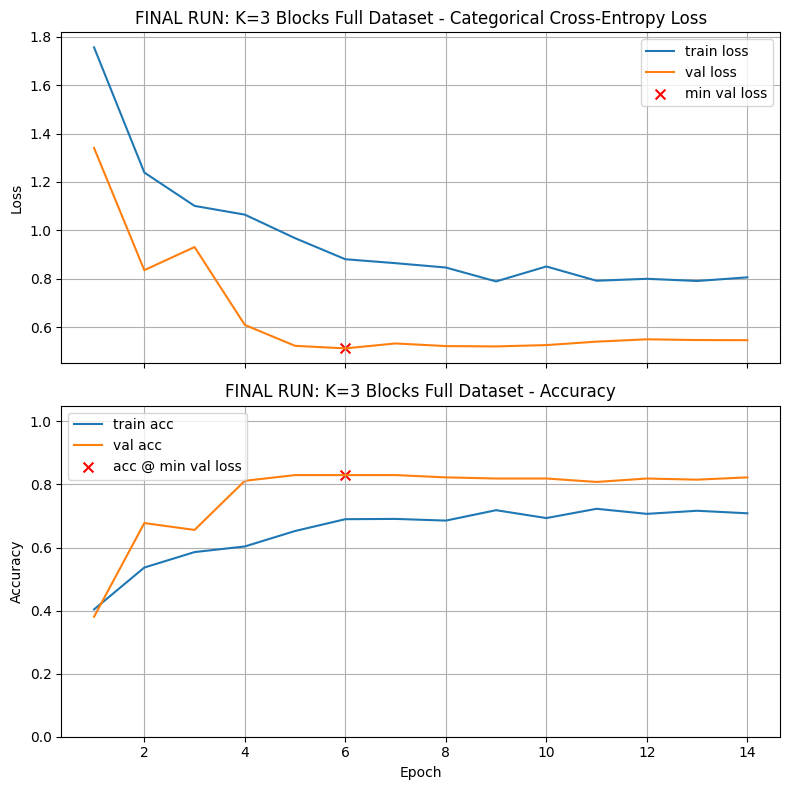

Final Training Loss:            0.8059
Final Training Accuracy:        0.7086
Final Validation Loss:          0.5463
Final Validation Accuracy:      0.8225
Minimum Validation Loss:        0.5124 (Epoch 6)
Validation Accuracy @ Min Loss: 0.8297

Test Loss: 0.5406
Test Accuracy: 0.8207

Validation-Test Gap (accuracy): 0.009043

Execution Time: 00:01:04


In [73]:
PROTO_TOTAL = None

final_block_model = build_block_unfrozen_model(K=3, unfreeze_bn=False, name_prefix="final")

train_and_test(
    final_block_model, 
    title="FINAL RUN: K=3 Blocks Full Dataset", 
    lr_schedule=1e-4, 
    epochs=25, 
    callbacks=[reduce_lr_blocks]
)

### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points. 

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when you have unfrozen some number K of Conv blocks?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., **number K of unfrozen blocks,** dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when you have unfrozen some number of blocks. 

**Your paragraph here (5pts):**




To systematically investigate how semantic, block-level fine-tuning impacts model convergence, I designed three experiments comparing a shallow unfreeze K=1, a deeper unfreeze K=3, and a configuration that tested the destabilizing effect of unfreezing the Batch Normalization layers. The shallowest configuration, unfreezing only the final K=1 block while strictly keeping all Batch Normalization layers frozen, performed the best during prototyping. This K=1 architecture likely outperformed the deeper unfreezing strategies because preserving the vast majority of the ImageNet feature hierarchies prevented catastrophic forgetting, while the multi-stage dense layers (512 to 128 to 32), aggressive dropout, and a robust 1e-4 learning rate managed by the ReduceLROnPlateau callback allowed the head to rapidly map those stable features to the new classes. Ultimately, this suggests that when unfreezing semantic blocks, restricting updates to only the very top stages while relying on a heavily regularized classification head and dynamic learning rate decay is a far more stable strategy than forcing deeper convolutional blocks to relearn complex spatial patterns.

**Validation accuracy (15pts):**

In [74]:
# Set a4 to the validation accuracy found by your best model for this problem. 

a4 = 0.8225           # Replace 0.0 with your answer

In [75]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4 = {a4:.4f}') 

a4 = 0.8225


## Problem 5: Final Reflection

Run the next cell and consider all your experiments in this homework. 

This reflection question is worth 5 points. 

In [71]:
# Print out summary of validation accuracy for each experiment

print_results()

More Layers                             	0.8877	42
Info Bottleneck                         	0.8841	6
80 Unfrozen                             	0.8841	47
Model Baseline                          	0.8804	8
Deep Regularized Head                   	0.8696	8
Exp 1: K=1 Block (BN Frozen)            	0.8659	18
Fixed with Small LR                     	0.8623	83
L2 Penalty                              	0.8551	12
20 Unfrozen                             	0.8370	249
FINAL RUN: K=3 Blocks Full Dataset      	0.7899	10
Exp 2: K=3 Blocks (BN Frozen)           	0.7319	10
Exp 3: K=3 Blocks (BN UNFROZEN)         	0.4493	12


### Graded Question

**Final Reflection:**
Looking at the validation accuracies across all your experiments run on the full dataset, what patterns or lessons stand out to you?

**Instructions:**
- Write a single paragraph (3–5 sentences).
- Comment on how your results compared across different experiments.
- Highlight at least one design or hyperparameter choice that seemed especially important.
- Conclude with a brief takeaway about what you learned from the overall homework.

**Your paragraph here (5pts):**





Across all experiments, fully unfreezing the backbone or unfreezing a massive chunk of individual layers (N=80) yielded the high validation accuracies, peaking at roughly 88.7%, whereas unfreezing deeper semantic blocks with a learning rate that was too large or unfreezing Batch Normalization layers caused performance to violently collapse down to 44.9%. Also creating more dense layers and funneling down from 512 to 128 to 32 performed very well. The most critical hyperparameter choice throughout the assignment was the pairing of a highly controlled, microscopic starting learning rate (such as 1e-4 or 3e-5) with the ReduceLROnPlateau callback. This combination, along with a heavily regularized multi-stage bottleneck head, acted as an automated braking system that protected the fragile pre-trained ImageNet weights from catastrophic forgetting. Ultimately, this homework demonstrated that successful transfer learning is less about blindly unfreezing layers and entirely about disciplined regularization, careful gradient management, and strictly preserving the mathematical stability of the original pre-trained model.

## Appendix:  What is MobileNetV2 (in plain English)?

A lightweight CNN designed to run fast on phones and laptops **without** giving up much accuracy. It achieves this with two ideas:

1. **Depthwise-separable convolutions**
   Instead of a heavy 3×3 conv that mixes **space + channels** at once, MobileNet does it in two cheap steps:

   * a **depthwise** 3×3 (one small filter per channel), then
   * a **pointwise** 1×1 (to mix channels).
     This slashes compute and parameters while keeping accuracy high. ([arXiv][1])

2. **Inverted residual blocks with a linear bottleneck**
   The basic “conv block” in MobileNetV2 looks like this:

   * **Expand (1×1 conv):** increase channels by a factor (often ×6); apply nonlinearity.
   * **Depthwise (3×3):** filter each channel separately; apply nonlinearity.
   * **Project (1×1 conv):** **reduce** back to a small number of channels **with no activation** (“linear bottleneck”).
     If input/output shapes match (stride = 1), add a **skip connection**.
     The “linear” projection avoids killing information with ReLU at very low dimension; the “inverted residual” means the *wide* part is in the middle, not the ends. ([arXiv][1])

---

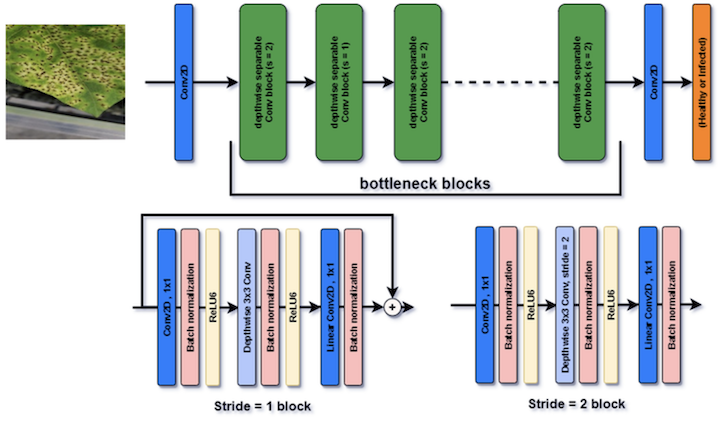


---

### What was MobileNetV2 trained on?

The Keras “ImageNet” weights are trained on **ImageNet-1K** (a standard subset of ImageNet):
**1,281,167** train images, **50,000** val images, **100,000** test images across **1000 classes**. Typical input size is **224×224**. ([ImageNet][2])

**Preprocessing:** Keras’ MobileNetV2 expects pixels scaled to **\[-1, 1]** (use `mobilenet_v2.preprocess_input`). ([keras.io][3])

---

### How Keras exposes it (what users will see)

* `tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False, pooling="avg")`
  returns a frozen **feature extractor** that outputs a 1280-D vector (after **global average pooling**).
* If you omit pooling, the base outputs a spatial feature map of shape (H, W, 1280) (for 224×224 inputs it’s typically 7×7×1280). You must then add a reducer before any Dense layers:

        Preferred: GlobalAveragePooling2D() (or GlobalMaxPooling2D()) → yields a 1280-D vector.

Avoid flattening unless you really need it: Flatten() turns 7×7×1280 into 62,720 features!

---

### Summary

* Think of each **MobileNetV2 block** as: **expand → depthwise → project (+ skip)**.
* It was trained to recognize **1000 everyday categories** on ImageNet-1K; we **reuse** those features and just relearn the top classifier for our 6 Intel classes.
* Always match **preprocessing** to the backbone (MobileNetV2 ⇒ **\[-1, 1]**). ([keras.io][3])


### See also:

- https://www.analyticsvidhya.com/blog/2023/12/what-is-mobilenetv2/
